# OpenAPS Exponential Insulin Activity and IOB Calculations
----
This notebook will replicate and visualize the calculation of insulin `activity` and `iob` used in the development branch for the next official release in the [OpenAPS project](https://github.com/openaps/oref0).

Specifically, it will replicate the javascript code found in [oref0/lib/iob/calculate.js](https://github.com/openaps/oref0/blob/dev/lib/iob/calculate.js) and plot the insulin `activity` curves and `iob` curves for a set of `dia` and `peak` values.

### First, some definitions:
* **dia:** Duration of Insulin Activity. This is the user specified time (in hours) that insulin lasts in their body after a bolus. This value comes from the user's pump settings. 


* **end:** Duration (in minutes) that insulin is active. `end` = `dia` * 60.


* **peak:** Duration (in minutes) when insulin action it's peak activity level.


* **activity:** The percentage of insulin that was active in the previous minute. 

    **Note:** The neither the code in the [master branch version of oref0/lib/iob/calculation.js](https://github.com/openaps/oref0/blob/master/lib/iob/calculate.js) or the code in the [dev branch version of oref0/lib/iob/calculation.js](https://github.com/openaps/oref0/blob/dev/lib/iob/calculate.js) calculates a variable called `activity`. Instead, it calculates a variable called `activityContrib`, which is I've broken into its two components: `activity` and `treatment.insulin`. I analyze `activity`, which is just the scaling factor applied to `treatment.insulin`.


In [1]:
import pandas as pd
import numpy as np
import math as Math
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def calc_exp_activity(minutes_to_peak):
    
    minutes_to_end = 300 # minutes
    
    peak_to_end = float(minutes_to_peak) / float(minutes_to_end)
    
    tau = (1.0 * minutes_to_peak) * (1 - peak_to_end) / (1 - 2 * peak_to_end)
    a = 2 * tau / (1.0 * minutes_to_end);
    S = 1 / (1 - a + (1 + a) * Math.exp(-(1.0 * minutes_to_end) / tau));
    
    
    #print peak_to_end
    #print tau
    #print a
    #print S
    
    x_list = []
    activity_list = [] 
    iob_list = []
    
    for i_min in range(0, minutes_to_end + 1):  # Add 1 to get plot at the last minute
                
        if (i_min < minutes_to_end + 1):   # Add 1 to get plot at the last minute
            x_list.append(i_min)
            
            activity = (S / Math.pow(tau, 2)) * i_min * (1 - i_min / (float(minutes_to_end))) * Math.exp(-i_min / tau)
            activity_list.append(activity)
            
            iob = (1 - S * (1 - a) * ((Math.pow(i_min, 2) / (tau * minutes_to_end * (1 - a)) - i_min / tau - 1) * Math.exp(-i_min / tau) + 1))
            iob_list.append(iob)
            
    return x_list, activity_list, iob_list

In [35]:
# Create a dictionary of DataFrames -- one for each value of DIA between 2 and 8
dict_of_dfs_by_peak = {}

for peak in range(60, 105, 15):                           # Note: range() ends at n-1
    x_list, activity_list, iob_list = calc_exp_activity(peak)
    activity_df = pd.DataFrame({'x' : x_list, 'activity_peak_' + str(peak) : activity_list, 'iob_peak_' + str(peak) : iob_list})
    
    # Add a cummulative sum column for activity
    activity_df['cum_activity_peak_' + str(peak)] = activity_df['activity_peak_' + str(peak)].cumsum()
   
    # Put df into a dictionary with dia as the key
    dict_of_dfs_by_peak.update({peak : activity_df})

In [36]:
dict_of_dfs_by_peak[75].head()

,activity_peak_75,iob_peak_75,x,cum_activity_peak_75
0,0.000000,1.000000,0,0.000000
1,0.000210,0.999895,1,0.000210
2,0.000415,0.999582,2,0.000625
3,0.000615,0.999066,3,0.001240
4,0.000810,0.998353,4,0.002050


In [37]:
dict_of_dfs_by_peak[75].tail()

,activity_peak_75,iob_peak_75,x,cum_activity_peak_75
296,0.000060,1.199543e-04,296,0.999891
297,0.000045,6.722575e-05,297,0.999936
298,0.000030,2.976795e-05,298,0.999966
299,0.000015,7.414518e-06,299,0.999981
300,0.000000,1.110223e-16,300,0.999981


In [6]:
# Peak activity 
dict_of_dfs_by_peak[75].iloc[74:77, :]

,activity_peak_75,x,cum_activity_peak_75
74,0.006140,74,0.324272
75,0.006141,75,0.330413
76,0.006140,76,0.336553


In [7]:
# Activity at 60 minutes
dict_of_dfs_by_peak[75].iloc[61, :]

activity_peak_75         0.006008
x                       61.000000
cum_activity_peak_75     0.244980
Name: 61, dtype: float64

In [8]:
# Activity at 120 minutes
dict_of_dfs_by_peak[75].iloc[121, :]

activity_peak_75          0.005236
x                       121.000000
cum_activity_peak_75      0.597270
Name: 121, dtype: float64

## Plot the Activity Curves!

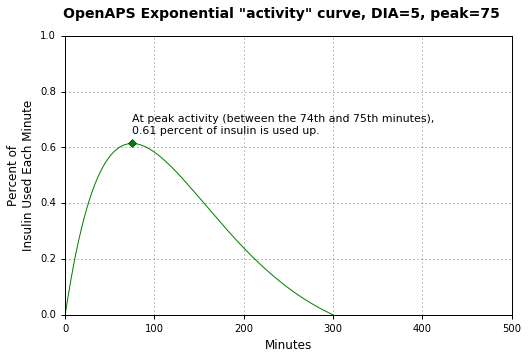

In [10]:
# Plot activity curve for just (peak == 75)
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Exponential "activity" curve, DIA=5, peak=75', fontsize=14, fontweight='bold')

markers = [75]

act_75_pct = dict_of_dfs_by_peak[75]['activity_peak_75'] * 100
act_75_pct.plot(kind='line', label='peak=75', color='g', marker='D', markevery=markers).grid(True)

plt.text(75, 0.65, 'At peak activity (between the 74th and 75th minutes),\n0.61 percent of insulin is used up.', fontsize=11)
#plt.text(140, 0.54, 'At two hours (between the 119th and 120th minutes),\n 0.62 percent of insulin is used up.', fontsize=11)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)

plt.xlim([0,500])
plt.ylim([0,1.0])

#plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.0)

#plt.savefig('OpenAPS_exponential_activity_dia_5_peak_75.png', format='png', dpi=600)

plt.show()

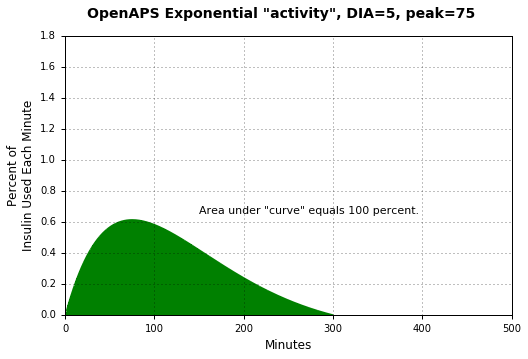

In [13]:
# Plot activity AREA UNDER curve 
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Exponential "activity", DIA=5, peak=75', fontsize=14, fontweight='bold')

# Create df with data in percentages
act_peak_75 = dict_of_dfs_by_peak[75]['activity_peak_75'] * 100 

ax_line = act_peak_75.plot(kind='line', label='DIA=5', color='g').grid(True)
ax_bar = act_peak_75.plot(kind='bar', edgecolor="none", width=1, label='Area under "curve"', color='g').grid(True)

plt.text(150, 0.65, 'Area under "curve" equals 100 percent.' , fontsize=11)
plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)

plt.xlim([0,500])
plt.xticks(np.arange(0,501,100), ('0', '100', '200', '300', '400', '500'), rotation='horizontal')
plt.ylim([0,1.8])

#plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.0)

#plt.savefig('OpenAPS_activity_dia_3_area.png', format='png', dpi=600)

plt.show()

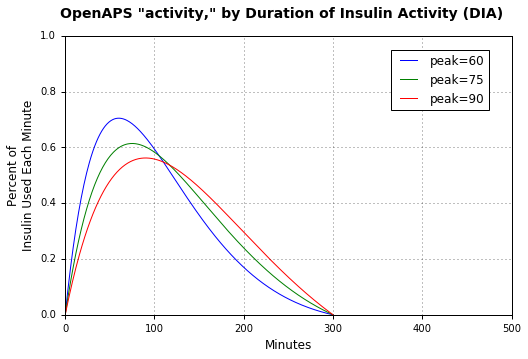

In [17]:
# Plot activity curve for dia = 5, peak = [60, 75, 90]
plt.figure(figsize=(8, 5))
plt.ylabel('Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS "activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for peak in [60, 75, 90]:
    peak_str = str(peak)
    (dict_of_dfs_by_peak[peak]['activity_peak_' + peak_str]*100).plot(kind='line', label='peak=' + peak_str).grid(True)

plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)    
    
plt.xlim([0,500])
plt.ylim([0,1.0])

plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)

#plt.savefig('OpenAPS_activity_by_dia_2_8.png', format='png', dpi=600)

plt.show()  

## Plot the Cumulative Activity Curves!

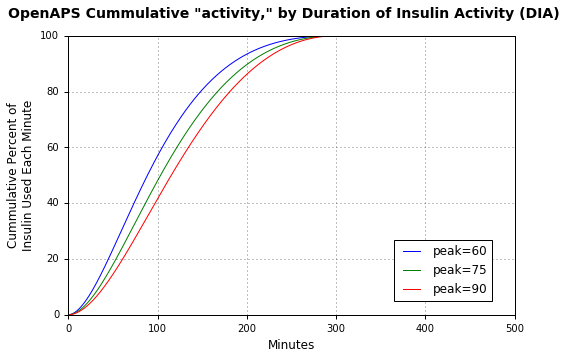

In [18]:
# Plot cumulative activity curves for dia = 5, peak = [60, 75, 90]
plt.figure(figsize=(8, 5))
plt.ylabel('Cummulative Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Cummulative "activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for peak in [60, 75, 90]:
    peak_str = str(peak)
    (dict_of_dfs_by_peak[peak]['cum_activity_peak_' + peak_str]*100).plot(kind='line', label='peak=' + peak_str).grid(True)
plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)
    
plt.xlim([0,500])
plt.ylim([0,100])
    
plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)

#plt.savefig('OpenAPS_cum_activity_by_dia_2_8.png', format='png', dpi=600)

plt.show()  

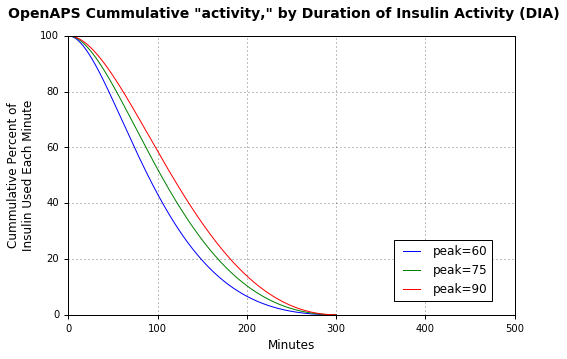

In [38]:
# Plot iob curves for dia = 5, peak = [60, 75, 90]
plt.figure(figsize=(8, 5))
plt.ylabel('Cummulative Percent of\nInsulin Used Each Minute', fontsize=12)
plt.xlabel('Minutes', fontsize=12)
plt.suptitle('OpenAPS Cummulative "activity," by Duration of Insulin Activity (DIA)', fontsize=14, fontweight='bold')

for peak in [60, 75, 90]:
    peak_str = str(peak)
    (dict_of_dfs_by_peak[peak]['iob_peak_' + peak_str]*100).plot(kind='line', label='peak=' + peak_str).grid(True)
plt.tick_params(axis='both', top='off', right='off', direction='out', pad=5, width=1)
    
plt.xlim([0,500])
plt.ylim([0,100])
    
plt.legend(bbox_to_anchor=(0.95, 0.05), loc=4, borderaxespad=0.)

#plt.savefig('OpenAPS_cum_activity_by_dia_2_8.png', format='png', dpi=600)

plt.show()  

# The End...